In [550]:
import pickle, os
import jieba
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [551]:
# gb18030编码收录的中文字符更全，对中文文档兼容性更好
df = pd.read_csv('sqlResult.csv',encoding='gb18030')
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89611 entries, 0 to 89610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       89611 non-null  int64 
 1   author   79396 non-null  object
 2   source   89609 non-null  object
 3   content  87054 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


,id,author,source,content
0,89617,NaN,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...
1,89616,NaN,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...
2,89615,NaN,快科技@http://www.kkj.cn/,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...
3,89614,NaN,新华社,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n
4,89613,胡淑丽_MN7479,深圳大件事,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...


In [552]:
with open('cn_stopwords.txt','r',encoding='utf-8') as file:
    stopwords = [line[:-1] for line in file.readlines()]
stopwords[:20]

['$',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '?',
 '_',
 '“',
 '”',
 '、',
 '。',
 '《',
 '》',
 '一']

In [553]:
df.dropna(subset=['content'],inplace=True)
df.dropna(subset=['source'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87052 entries, 0 to 89610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       87052 non-null  int64 
 1   author   76925 non-null  object
 2   source   87052 non-null  object
 3   content  87052 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.3+ MB


In [554]:
def split_text(text):
  text = text.replace(' ', '').replace('\n','').replace('\r','')
  text2 = jieba.cut(text)
  result = ' '.join([w for w in text2 if w not in stopwords])#以停止词为参考拆分文章
  return result

temp = df.iloc[0].content
temp
split_text(temp)


'本周 （ 月 12 日 ） 小米 手机 15 款 机型 外 机型 暂停 更新 发布 （ 含 开发 版 / 体验版 内测 稳定版 暂不受 影响 ） 确保 工程师 集中 精力 进行 系统优化 工作 有人 猜测 精力 主要 用到 MIUI9 研发 之中 MIUI8 去年 月 发布 距今已有 一年 有余 更新换代 MIUI9 确切 信息 等待 官方消息'

In [555]:
# 假如路径存在，则直接读取，否则进行分词，并保存到本地
if os.path.exists('corpus.pkl'):
    with open('corpus.pkl', 'rb') as file:
        corpus = pickle.load(file)
else:
    corpus = df['content'].map(split_text)
    # 保存到本地，方便下次读取
    with open('corpus.pkl', 'wb') as file:
        pickle.dump(corpus, file)

In [556]:
len(set(corpus[0].split()))#文章中不重复的单词的数量

48

In [557]:
corpus

0        本周 （ 月 12 日 ） 小米 手机 15 款 机型 外 机型 暂停 更新 发布 （ 含 ...
1        骁龙 835 唯一 Windows10 桌面 平台 认证 ARM 处理器 高通 强调 不会 ...
2        此前 一加 3T 搭载 3400mAh 电池 DashCharge 快充 规格 5V / 4...
3        这是 月 18 日 葡萄牙 中部 佩德罗 冈 地区 拍摄 森林 大火 烧毁 汽车 新华社 记...
4        （ 原 标题 44 岁 女子 跑 深圳 约会 网友 拒 暴雨 中 裸身 奔走 … … ） @...
                               ...                        
89606    新华社 照片 多伦多 2017 年 月 日 \ n （ 体育 ） （ ） 冰球 — — 国家...
89607    新华社 兰州 月 日电 （ 王衡 徐丹 ） 记者 甘肃省 交通运输 厅 获悉 甘肃 近日 集...
89608    \ n \ n2017 年 月 29 日 法国巴黎 郊外 凡尔赛宫 法国 总统 马克 龙 出...
89609    \ n \ n2017 年 月 25 日 美国 马萨诸塞州 剑桥市 哈佛大学 毕业生 毕业典...
89610    　 　 新华社 德国 杜塞尔多夫 ６ 月 ６ 日电 题 乒乓 女球迷 　 \ n 　 　 新...
Name: content, Length: 87052, dtype: object

In [558]:
countvectorizer = CountVectorizer(encoding='utf-8',min_df=0.015)
countvector = countvectorizer.fit_transform(corpus)
countvector.shape
print(countvector[:1])

  (0, 3)	1
  (0, 449)	1
  (0, 6)	1
  (0, 265)	2
  (0, 407)	1
  (0, 422)	1
  (0, 648)	1
  (0, 831)	1
  (0, 797)	1
  (0, 376)	1
  (0, 105)	1
  (0, 646)	1
  (0, 257)	1
  (0, 49)	1
  (0, 171)	1


In [559]:
countvector_arr = countvector.toarray()#各个词语在文章中出现的次数
countvector_arr.shape

(87052, 855)

In [560]:
words_indices = countvectorizer.vocabulary_
len(words_indices)
list(words_indices.items())[:4]
words_indices = sorted(words_indices.items(),key=lambda x: x[1], reverse=False)
words_indices[-5:]


[('首次', 850), ('首轮', 851), ('首都', 852), ('香港', 853), ('鼓励', 854)]

In [561]:
feature_names = countvectorizer.get_feature_names_out()#关键词列表
print(feature_names[:5])
stop_wds = countvectorizer.stop_words_
print(list(stop_wds)[:5])

['10' '100' '11' '12' '13']
['空客', '李豪岩', '产奶量', '抬丧歌', '替人着想']


In [562]:
tfidftransformer = TfidfTransformer()
tfidf = tfidftransformer.fit_transform(countvector)
print(tfidf[0])

  (0, 831)	0.27224738970811185
  (0, 797)	0.1535479708591252
  (0, 648)	0.27197992426463447
  (0, 646)	0.28822734916018905
  (0, 449)	0.29304853186362373
  (0, 422)	0.22131702185602292
  (0, 407)	0.26833438115163655
  (0, 376)	0.1883631082306349
  (0, 265)	0.4393830778179688
  (0, 257)	0.23334186190460163
  (0, 171)	0.23884389263545713
  (0, 105)	0.20471339371863817
  (0, 49)	0.26702123831020386
  (0, 6)	0.21060763927727227
  (0, 3)	0.20198469485745432


In [563]:
tfidftransformer.idf_[:5]

array([3.22548834, 4.52300041, 3.49021635, 3.48331119, 3.66596311])

In [565]:
df['source'].value_counts()
label = df['source'].copy()
label.str.contains('新华').sum()
target = label.str.contains('新华') * 1

In [566]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(tfidf.toarray(),target,test_size=0.2)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((69641, 855), (17411, 855), (69641,), (17411,))

In [567]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
estimator = MultinomialNB()
estimator.fit(x_train,y_train)

MultinomialNB()

In [572]:
y_pred = estimator.predict(x_test)
print(classification_report(y_test,y_pred,labels=[0,1],target_names=['others','新华']))

              precision    recall  f1-score   support

      others       0.42      0.64      0.50      1659
          新华       0.96      0.91      0.93     15752

    accuracy                           0.88     17411
   macro avg       0.69      0.77      0.72     17411
weighted avg       0.91      0.88      0.89     17411



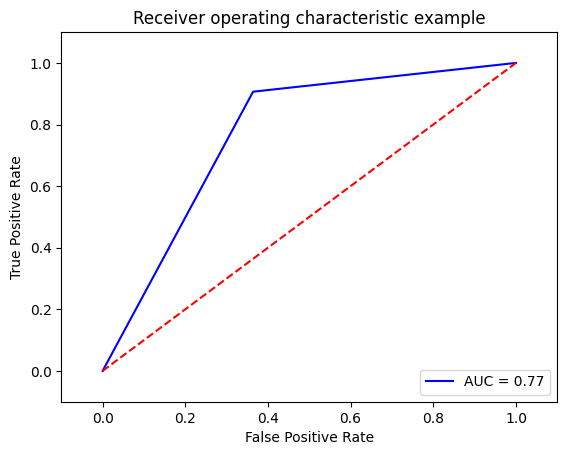

In [573]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_probs = estimator.predict_proba(x_test)               #模型的预测得分
fpr, tpr, thresholds = roc_curve(y_test,y_pred, pos_label=None, sample_weight=None, drop_intermediate=True)
roc_auc = auc(fpr, tpr)                                     #auc为Roc曲线下的面积
#开始画ROC曲线
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.xlabel('False Positive Rate')                            #横坐标是fpr
plt.ylabel('True Positive Rate')                             #纵坐标是tpr
plt.title('Receiver operating characteristic example')
plt.show()